In [1]:
!pip install geonamescache folium streamlit-folium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.8 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/georetail-ai-processed-data/cities_with_econ.csv
/kaggle/input/georetail-ai-processed-data/world_cities_updated.csv
/kaggle/input/georetail-ai-processed-data/cities_final_ranked.csv
/kaggle/input/georetail-ai-processed-data/store_locations.csv


In [3]:
import pandas as pd

BASE = "/kaggle/input/georetail-ai-processed-data"

# 1) Raw world cities
world = pd.read_csv(f"{BASE}/world_cities_updated.csv")

# 2) Economic features (log-pop, GDP, econ_viability)
econ  = pd.read_csv(f"{BASE}/cities_with_econ.csv")

# 3) Sample store locations
stores = pd.read_csv(f"{BASE}/store_locations.csv")

# 4) Final merged & scored
final = pd.read_csv(f"{BASE}/cities_final_ranked.csv")

# Quick sanity check
print("World:", world.shape)
print("Econ :", econ.shape)
print("Stores:", stores.shape)
print("Final:", final.shape)

final.head()


World: (26463, 5)
Econ : (26353, 9)
Stores: (15, 4)
Final: (26353, 13)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name,countrycode,latitude,longitude,population,log_population,iso3,gdp_per_capita,econ_viability,city_name,store_count,comp_intensity,expansion_score
0,les Escaldes,AD,42.50729,1.53414,15853,9.671177,AND,42414.059009,0.107241,NaN,0,0,0.107241
1,Andorra la Vella,AD,42.50779,1.52109,20430,9.924809,AND,42414.059009,0.110053,NaN,0,0,0.110053
2,Umm Al Quwain City,AE,25.56473,55.55517,62747,11.046882,ARE,49899.065298,0.144113,NaN,0,0,0.144113
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943,12.771227,ARE,49899.065298,0.166608,NaN,0,0,0.166608
4,Zayed City,AE,23.65416,53.70522,63482,11.058527,ARE,49899.065298,0.144265,NaN,0,0,0.144265


## 1. Data Preview

Let’s take a quick look at each DataFrame—its columns, a few rows, and basic summary stats—so we know exactly what we’re working with.


In [4]:
# Preview world cities
print("❯ world_cities_updated.csv shape:", world.shape)
display(world.head())

# Preview econ features
print("❯ cities_with_econ.csv shape:", econ.shape)
display(econ.head())

# Preview store locations
print("❯ store_locations.csv shape:", stores.shape)
display(stores.head())

# Preview final ranked
print("❯ cities_final_ranked.csv shape:", final.shape)
display(final.head())


❯ world_cities_updated.csv shape: (26463, 5)


,name,countrycode,latitude,longitude,population
0,les Escaldes,AD,42.50729,1.53414,15853
1,Andorra la Vella,AD,42.50779,1.52109,20430
2,Umm Al Quwain City,AE,25.56473,55.55517,62747
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943
4,Zayed City,AE,23.65416,53.70522,63482


❯ cities_with_econ.csv shape: (26353, 9)


,name,countrycode,latitude,longitude,population,log_population,iso3,gdp_per_capita,econ_viability
0,les Escaldes,AD,42.50729,1.53414,15853,9.671177,AND,42414.059009,0.107241
1,Andorra la Vella,AD,42.50779,1.52109,20430,9.924809,AND,42414.059009,0.110053
2,Umm Al Quwain City,AE,25.56473,55.55517,62747,11.046882,ARE,49899.065298,0.144113
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943,12.771227,ARE,49899.065298,0.166608
4,Zayed City,AE,23.65416,53.70522,63482,11.058527,ARE,49899.065298,0.144265


❯ store_locations.csv shape: (15, 4)


,store_id,latitude,longitude,city_name
0,1,19.0760,72.8777 # Mumbai,India
1,2,28.7041,77.1025 # Delhi,India
2,3,12.9716,77.5946 # Bengaluru,India
3,4,13.0827,80.2707 # Chennai,India
4,5,22.5726,88.3639 # Kolkata,India


❯ cities_final_ranked.csv shape: (26353, 13)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name,countrycode,latitude,longitude,population,log_population,iso3,gdp_per_capita,econ_viability,city_name,store_count,comp_intensity,expansion_score
0,les Escaldes,AD,42.50729,1.53414,15853,9.671177,AND,42414.059009,0.107241,NaN,0,0,0.107241
1,Andorra la Vella,AD,42.50779,1.52109,20430,9.924809,AND,42414.059009,0.110053,NaN,0,0,0.110053
2,Umm Al Quwain City,AE,25.56473,55.55517,62747,11.046882,ARE,49899.065298,0.144113,NaN,0,0,0.144113
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943,12.771227,ARE,49899.065298,0.166608,NaN,0,0,0.166608
4,Zayed City,AE,23.65416,53.70522,63482,11.058527,ARE,49899.065298,0.144265,NaN,0,0,0.144265


In [5]:
# Basic info & summary
for name, df_ in [("world", world), ("econ", econ), ("stores", stores), ("final", final)]:
    print(f"\n>>=== {name} DataFrame Info ===")
    display(df_.info())
    display(df_.describe(include="all").T)



>>=== world DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26463 entries, 0 to 26462
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         26463 non-null  object 
 1   countrycode  26449 non-null  object 
 2   latitude     26463 non-null  float64
 3   longitude    26463 non-null  float64
 4   population   26463 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.0+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,26463,24993,Richmond,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countrycode,26449,243,US,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,26463.0,NaN,NaN,NaN,27.859795,22.624551,-54.81084,15.73213,34.05,43.78596,78.22334
longitude,26463.0,NaN,NaN,NaN,17.95317,73.026715,-176.17453,-46.31347,16.46829,77.61194,179.36451
population,26463.0,NaN,NaN,NaN,123019.454257,527923.226045,0.0,21986.5,35604.0,74433.0,22315474.0



>>=== econ DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26353 entries, 0 to 26352
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            26353 non-null  object 
 1   countrycode     26353 non-null  object 
 2   latitude        26353 non-null  float64
 3   longitude       26353 non-null  float64
 4   population      26353 non-null  int64  
 5   log_population  26353 non-null  float64
 6   iso3            26353 non-null  object 
 7   gdp_per_capita  26353 non-null  float64
 8   econ_viability  26353 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,26353,24897,Richmond,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countrycode,26353,215,US,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,26353.0,NaN,NaN,NaN,27.953367,22.570022,-54.81084,15.85851,34.09529,43.82602,69.96887
longitude,26353.0,NaN,NaN,NaN,17.919332,72.995582,-175.20114,-46.14,16.43333,77.59438,179.36451
population,26353.0,NaN,NaN,NaN,122848.663644,526700.388978,0.0,22000.0,35641.0,74406.0,22315474.0
log_population,26353.0,NaN,NaN,NaN,10.757953,1.055707,0.0,9.998843,10.48128,11.217305,16.920791
iso3,26353,215,USA,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,26353.0,NaN,NaN,NaN,26406.245151,26517.959662,250.634225,4730.745489,12662.582671,45935.927647,226052.001905
econ_viability,26353.0,NaN,NaN,NaN,0.073153,0.073062,0.0,0.013384,0.038702,0.124675,0.614819



>>=== stores DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   store_id   15 non-null     int64  
 1   latitude   15 non-null     float64
 2   longitude  15 non-null     object 
 3   city_name  14 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 612.0+ bytes


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
store_id,15.0,NaN,NaN,NaN,8.0,4.472136,1.0,4.5,8.0,11.5,15.0
latitude,15.0,NaN,NaN,NaN,22.723273,20.811103,-33.8688,15.23385,23.5505,34.87085,51.5074
longitude,15,15,72.8777 # Mumbai,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_name,14,8,India,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN



>>=== final DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26353 entries, 0 to 26352
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             26353 non-null  object 
 1   countrycode      26353 non-null  object 
 2   latitude         26353 non-null  float64
 3   longitude        26353 non-null  float64
 4   population       26353 non-null  int64  
 5   log_population   26353 non-null  float64
 6   iso3             26353 non-null  object 
 7   gdp_per_capita   26353 non-null  float64
 8   econ_viability   26353 non-null  float64
 9   city_name        0 non-null      float64
 10  store_count      26353 non-null  int64  
 11  comp_intensity   26353 non-null  int64  
 12  expansion_score  26353 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 2.6+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,26353,24897,Richmond,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countrycode,26353,215,US,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,26353.0,NaN,NaN,NaN,27.953367,22.570022,-54.81084,15.85851,34.09529,43.82602,69.96887
longitude,26353.0,NaN,NaN,NaN,17.919332,72.995582,-175.20114,-46.14,16.43333,77.59438,179.36451
population,26353.0,NaN,NaN,NaN,122848.663644,526700.388978,0.0,22000.0,35641.0,74406.0,22315474.0
log_population,26353.0,NaN,NaN,NaN,10.757953,1.055707,0.0,9.998843,10.48128,11.217305,16.920791
iso3,26353,215,USA,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,26353.0,NaN,NaN,NaN,26406.245151,26517.959662,250.634225,4730.745489,12662.582671,45935.927647,226052.001905
econ_viability,26353.0,NaN,NaN,NaN,0.073153,0.073062,0.0,0.013384,0.038702,0.124675,0.614819
city_name,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Feature Engineering

1. **Clean** the `world` DataFrame (drop nulls, filter small populations)  
2. **Merge** `econ` onto `world` by `name` + `countrycode`  
3. **Count** stores per city from `stores` and merge into the result  
4. **Compute** `comp_intensity` = `store_count / max(store_count)`  
5. **Compute** `expansion_score` = `econ_viability * (1 - comp_intensity)`


In [6]:
# 2.1 Clean the world DataFrame
df_clean = world.dropna(subset=['name','latitude','longitude','population'])
df_clean = df_clean[df_clean.population > 10000]
df_clean.head()


,name,countrycode,latitude,longitude,population
0,les Escaldes,AD,42.50729,1.53414,15853
1,Andorra la Vella,AD,42.50779,1.52109,20430
2,Umm Al Quwain City,AE,25.56473,55.55517,62747
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943
4,Zayed City,AE,23.65416,53.70522,63482


In [7]:
# 2.2 Merge econ features
df_feats = df_clean.merge(
    econ,
    on=['name','countrycode'],
    how='left'
)
df_feats.head()


,name,countrycode,latitude_x,longitude_x,population_x,latitude_y,longitude_y,population_y,log_population,iso3,gdp_per_capita,econ_viability
0,les Escaldes,AD,42.50729,1.53414,15853,42.50729,1.53414,15853.0,9.671177,AND,42414.059009,0.107241
1,Andorra la Vella,AD,42.50779,1.52109,20430,42.50779,1.52109,20430.0,9.924809,AND,42414.059009,0.110053
2,Umm Al Quwain City,AE,25.56473,55.55517,62747,25.56473,55.55517,62747.0,11.046882,ARE,49899.065298,0.144113
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943,25.78953,55.94320,351943.0,12.771227,ARE,49899.065298,0.166608
4,Zayed City,AE,23.65416,53.70522,63482,23.65416,53.70522,63482.0,11.058527,ARE,49899.065298,0.144265


In [8]:
# 2.3 Count stores per city
store_counts = (
    stores
    .groupby("city_name")
    .size()
    .rename("store_count")
    .reset_index()
)

# Merge back into df_feats
df_feats = df_feats.merge(
    store_counts,
    left_on="name",
    right_on="city_name",
    how="left"
)

# Fill missing → zero stores
df_feats["store_count"] = df_feats["store_count"].fillna(0).astype(int)

df_feats.head()


,name,countrycode,latitude_x,longitude_x,population_x,latitude_y,longitude_y,population_y,log_population,iso3,gdp_per_capita,econ_viability,city_name,store_count
0,les Escaldes,AD,42.50729,1.53414,15853,42.50729,1.53414,15853.0,9.671177,AND,42414.059009,0.107241,NaN,0
1,Andorra la Vella,AD,42.50779,1.52109,20430,42.50779,1.52109,20430.0,9.924809,AND,42414.059009,0.110053,NaN,0
2,Umm Al Quwain City,AE,25.56473,55.55517,62747,25.56473,55.55517,62747.0,11.046882,ARE,49899.065298,0.144113,NaN,0
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943,25.78953,55.94320,351943.0,12.771227,ARE,49899.065298,0.166608,NaN,0
4,Zayed City,AE,23.65416,53.70522,63482,23.65416,53.70522,63482.0,11.058527,ARE,49899.065298,0.144265,NaN,0


In [9]:
# 2.4 Competitive intensity = relative store density (0–1)
max_stores = df_feats["store_count"].max()

df_feats["comp_intensity"] = df_feats["store_count"] / max_stores

# If you want to guard against division-by-zero:
df_feats["comp_intensity"] = df_feats["comp_intensity"].fillna(0)

df_feats.head()


,name,countrycode,latitude_x,longitude_x,population_x,latitude_y,longitude_y,population_y,log_population,iso3,gdp_per_capita,econ_viability,city_name,store_count,comp_intensity
0,les Escaldes,AD,42.50729,1.53414,15853,42.50729,1.53414,15853.0,9.671177,AND,42414.059009,0.107241,NaN,0,0.0
1,Andorra la Vella,AD,42.50779,1.52109,20430,42.50779,1.52109,20430.0,9.924809,AND,42414.059009,0.110053,NaN,0,0.0
2,Umm Al Quwain City,AE,25.56473,55.55517,62747,25.56473,55.55517,62747.0,11.046882,ARE,49899.065298,0.144113,NaN,0,0.0
3,Ras Al Khaimah City,AE,25.78953,55.94320,351943,25.78953,55.94320,351943.0,12.771227,ARE,49899.065298,0.166608,NaN,0,0.0
4,Zayed City,AE,23.65416,53.70522,63482,23.65416,53.70522,63482.0,11.058527,ARE,49899.065298,0.144265,NaN,0,0.0


In [10]:
# 2.5 Expansion score = econ_viability * (1 − comp_intensity)
df_feats["expansion_score"] = (
    df_feats["econ_viability"] * 
    (1 - df_feats["comp_intensity"])
)

# View your top 10 picks
top10 = df_feats.nlargest(10, "expansion_score")
top10[["name", "econ_viability", "store_count", "comp_intensity", "expansion_score"]]


,name,econ_viability,store_count,comp_intensity,expansion_score
16635,Monaco,0.614819,0,0.0,0.614819
16634,Monte-Carlo,0.572146,0,0.0,0.572146
11363,Dublin,0.384226,0,0.0,0.384226
18373,Oslo,0.377477,0,0.0,0.377477
16489,Luxembourg,0.367584,0,0.0,0.367584
21668,Singapore,0.359385,0,0.0,0.359385
18396,Bergen,0.357357,0,0.0,0.357357
11378,South Dublin,0.348101,0,0.0,0.348101
18363,Trondheim,0.338461,0,0.0,0.338461
18367,Stavanger,0.338021,0,0.0,0.338021


## 3. Visualizations

We’ll display the top 10 expansion cities on an interactive Folium map and then show a bar chart of their expansion scores.


In [11]:
import folium
from streamlit_folium import st_folium  # if you plan to port to Streamlit; on Kaggle this isn’t needed

# Prepare the top10 DataFrame
top10 = final.nlargest(10, "expansion_score")


# Build the map
m = folium.Map(
    location=[
        top10["latitude"].mean(),
        top10["longitude"].mean()
    ],
    zoom_start=2,
    tiles="cartodbpositron"
)

# Add circle markers
for _, city in top10.iterrows():
    folium.CircleMarker(
        location=(city.latitude, city.longitude),
        radius=5 + city.expansion_score * 40,
        popup=(
            f"<b>{city.name}</b><br>"
            f"Econ Viability: {city.econ_viability:.3f}<br>"
            f"Store Count: {city.store_count}<br>"
            f"Expansion Score: {city.expansion_score:.3f}"
        ),
        color="crimson",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Render inline
m


2025-04-27 17:19:08.533 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


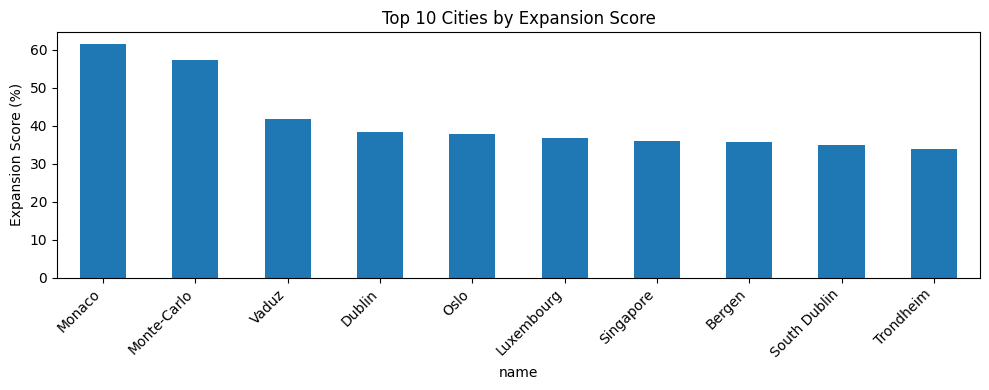

In [12]:
import matplotlib.pyplot as plt

# 3.2 Bar Chart of Expansion Scores
# Prepare the data
scores = top10.set_index("name")["expansion_score"] * 100  # convert to %

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
scores.plot.bar(ax=ax)
ax.set_title("Top 10 Cities by Expansion Score")
ax.set_ylabel("Expansion Score (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


---
**Conclusion**

This notebook demonstrated how to:
1. Clean and enrich global city data with economic features.
2. Compute competitive intensity from store locations.
3. Score and rank cities for retail expansion.
4. Visualize results with Folium and Matplotlib.


In [13]:
print(top10.columns.tolist())


['name', 'countrycode', 'latitude', 'longitude', 'population', 'log_population', 'iso3', 'gdp_per_capita', 'econ_viability', 'city_name', 'store_count', 'comp_intensity', 'expansion_score']


In [14]:
df = world.dropna(subset=['name','latitude','longitude','population'])
df = df[df.population > 10000]


In [15]:
df = df.merge(econ, on=['name','countrycode'], how='left')


In [16]:
store_counts = stores.groupby('city_name').size().rename('store_count').reset_index()
df = df.merge(store_counts, left_on='name', right_on='city_name', how='left').fillna({'store_count':0})


In [17]:
df['comp_intensity'] = df.store_count / df.store_count.max()
df['expansion_score'] = df.econ_viability * (1 - df.comp_intensity)
